This notebook is aimed at summarzing the REPET output at different levels of the nomenclature and to plot this out. Parts of it are really slow.


This notebook was only designed for the purpose of analyzing the Pst-104E genome. No gurantees it works in any other situtation. It will have spelling errors due to the lack of autocorrection.

In [1]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt
import json
from ipywidgets import widgets
from IPython.display import display
from sklearn.externals.joblib import Parallel, delayed
import seaborn as sns
import matplotlib
import subprocess

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [2]:
def ID_filter_gff(_feature, _id):
    """
    This filter parses out the top level id form the 9th gff column form a REPET gff file.
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    This function expects that the variable genome either ends with p_ctg or h_ctg and adapts the
    search pattern accordingly.
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        if genome.endswith('p_ctg'):
            TE_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)'
        elif genome.endswith('h_ctg'):
            TE_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([^;| ]*)'
        TE_prog = re.compile(TE_pattern)
        TE_match = TE_prog.search(_id)

        try:
            return TE_match.group(1)
        except AttributeError:
            print(_id)

    if _type == 'REPET_SSRs':
        if genome.endswith('p_ctg'):
            SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        elif genome.endswith('h_ctg'):
            SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        SSR_prog = re.compile(SSR_pattern)
        SSR_match = SSR_prog.search(_id)
        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        if genome.endswith('p_ctg'):
            blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)')
        elif genome.endswith('h_ctg'):
             blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([^;| ]*)')
        #blast_prog = re.compile(blast_pattern)
        blast_match = blast_prog.search(_id)
        return blast_match.group(1)


In [3]:
def blast_hit_gff(_feature, _row8, _id):
    """
    This filter parses the blast hit for REPET_TEs from the new 'ID' column. If no blast hit available returns Pastec ids.
    If the result is blast already the value is simple parse the blast hit.
    SSRs also get SSR
    !!!Requires the three_letter_dict to be defined previously.!!!
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        #split the pastec_cat into the first three letter code
        #the spliting of the 'ID' column needs to be done differently depending on the h or p contigs.
        #h contigs contain one additional '_' in the contig id

        pastec_cat = _id.split('_')[0]
        if 'TE_BLR' in _row8:
            #hit_list = [x.split(';')[3] for x in _row8]
            blast_hit_pattern = r'TE_BLR\w*: (\S*)[ |;]'
            blast_hit_prog = re.compile(blast_hit_pattern)
            TE_match = blast_hit_prog.findall(_row8)
            first_sub_class = ':'.join(TE_match[0][:-1].split(':')[1:])
            if len([x for x in TE_match if first_sub_class in x]) == len(TE_match):
                if ';' in first_sub_class:
                    return first_sub_class.split(';')[0]
                else:
                    return first_sub_class
#fix this here to include the there letter code of the first bit of the ID similar to the blast hits
#e.g. ClassI:?:? and so on. a dict might be the easiest here.
            
            else:
                return three_letter_dict[pastec_cat]
        else:
            return three_letter_dict[pastec_cat]
    if _type == 'REPET_SSRs':
        return 'SSR'
        

        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        return ':'.join(_id.split(':')[1:])

In [4]:
def TE_classification_filter(_id, level = 0):
    """
    This function pulls out the class == level1, Order == level2, Superfamily == leve3.
    If SSR or noCat return these values.
    
    """
    if len(_id.split(':')) == 1:
        return _id
    if level == 0:
        _class = _id.split(':')[0]
        if _class == 'ClassI':
            return 'Retrotransposon'
        if _class == 'ClassII':
            return 'DNA_transposon'
    elif level == 1:
        _order = _id.split(':')[1]
        if _order == '?':
            return 'noCat'
        else:
            return _order
    elif level == 2:
        _superfamily = _id.split(':')[2]
        if _superfamily == '?':
            return 'noCat'
        else:
            return _superfamily
    else:
        print('Something wrong! Check if level is 0, 1 or 2')

In [5]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id(_id, bed_fh, repet_prefix, genome_file_fh):
    '''A function that takes the a ID, e.g. from the ID column 9 of a gff,
    a bed file handle, e.g. the gff frame, a certain file prefix, and a genome_file handle.
    It saves out the coverage file and the gff file for the specific ID.'''
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id == 'noCat':
        out_path = TE_path_dict['noCat']
    #everything without '_' at the end should be SSR
    elif _id == 'SSR':
        out_path = TE_path_dict['SSR']
    cov_fh = os.path.join(out_path,'%s.%s.cov' %(repet_prefix,_id))
    gff_fh = cov_fh.replace('.cov', '.gff')
    result = pybedtools.BedTool(bed_fh).filter(id_filter, _id).saveas(gff_fh)
    result.genome_coverage(dz=True,g=genome_file_fh).saveas(cov_fh)
    print('Done with callculating coverage of %s.'% _id)

In [6]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [7]:
def samcov_slurp(file_name, mean=False, fil=True):
    """
    Function that slurps in the the file via the file_name and tests if looks a samcov file.
    If this is the case it makes a dataframe out of the samcov file and calculates the following values.
    Ave_cov per window, which is the average coverage for each genomic interval. 
    Norm_cov per window, is the normalized coverage for each genomic interavl. This
    can be either calculated by via the mean coverage of the dataframe or via a provided mean.
    """
    if file_name.endswith('.samcov') == False:
        print("%s Might not be a samcov file. Please check" % file_name)
        return False
        
    samcov_header_bed_3 = ['contig', 'start', 'stop', 'total_cov']
    samcov_header_bed_6 = ['contig', 'start', 'stop', 'ID', 'score', 'strand','total_cov']
    df = pd.read_csv(file_name, sep='\t', header=None)
    if len(df.columns) == 4:
        df.rename(columns=dict(zip(df.columns, samcov_header_bed_3)), inplace=True)
    elif len(df.columns) == 7:
        df.rename(columns=dict(zip(df.columns, samcov_header_bed_6)), inplace=True)
    else:
        print("%s Might not be a samcov file. Please check" % file_name)
        return False
    
    df['interval_size'] = (df.stop-df.start)
    df['ave_cov'] = df.total_cov/df['interval_size']
    if mean == False:
        df_mean = sum(df.total_cov)/sum(df.interval_size)
        df['norm_cov'] = df['ave_cov']/df_mean
    else:
        df['norm_cov'] = df['ave_cov']/mean
    #rounder = pd.Series([0,0,0,0,2], index = df.columns)
    df.ave_cov = df.ave_cov.round()
    if fil == True:
        low = 0 #these were defined empirical based on the iqr caculations using 0.01 
        high = 400 #and 0.99 as cut off.
        df = df[(df.ave_cov >= low) & (df.ave_cov <= high)]
    return df

In [8]:
def run_samtools_bedcov(window_bed_fn, bam_fn, output_fh):
    """Runs samtools bedcov as a subprocess so we can paralize the different runs saving some time.
    Input: 
    The window_bed fn for which the samtools bedcov should be calculated.
    The bam_fn file that contains the read mapping.
    The output_fn where the output is saved to.
    These should be absolute path"""
    cmd = r'samtools bedcov %s %s > %s' % (window_bed_fn, bam_fn,output_fh)
    stderr = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT)
    print('Done with %s' % cmd)

### Description
This notebook runs on DK0911v03/4 which are the same as the pwoh to h re-assignment has already been completed. 
REPET was run in the two round annotation mode (see /home/benjamin/genome_assembly/Warrior/REPET/TEanno/primary/TEanno01_finish.sh) for details. The repeat database was 104Ep_DK0911p/104Ep_DK0911p_withoutRedundancy.fa which was produced by combining newly discovered REPEATs from DK0911 and Pst104Ep. The classif_table in the SQL was 104Ep_DK0911p_classif.
All REPET gff files got combined as follows using the the naming convention GENOME.DENOVODATABASE.REPET.gff.  

This is the summary for the haplotigs with the same settings as for the primary contigs the folder is /home/benjamin/genome_assembly/Warrior/REPET/TEanno/haplotigs


DK_0911_v04_p_ctg.104Ep_DK0911p.REPET.gff3

### Change following input here.

In [9]:
source_dir = '/home/benjamin/genome_assembly/Warrior/genome_v04/'
genome = 'DK_0911_v04_h_ctg'
#in case the genome version for the REPET run had a different ID.
genome_repet = 'DK0911v04ha1'
Tenovodb = '104Ep_DK0911p'
out_dir = '/home/benjamin/genome_assembly/Warrior/TE_analysis'
repet_db_dir = '/home/benjamin/databases/REPET'
#This needs to be updated here according to genome
TE_postanalysis_dir = '/home/benjamin/genome_assembly/Warrior/REPET/TEanno/haplotigs/TEanno_full/postanalysis'
#threads to use for multithreading
threads = 4

In [78]:
##OUTPATH for figures
OUTPATH='/home/benjamin/genome_assembly/Warrior/DK0911_v04/figures'

In [10]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [11]:
#remove all commenting lines from the initial repet file
!grep -v "^#" {source_dir}/{genome}.{Tenovodb}.REPET.gff3 > {out_dir}/{genome}.{Tenovodb}.REPET.gff3

In [12]:
#read in repet_gff file
repet_gff = pd.read_csv(os.path.join(out_dir, '%s.%s.REPET.gff3'%(genome,Tenovodb)), sep='\t', header=None)

In [13]:
TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')

In [14]:
TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']

In [15]:
!ls {TE_postanalysis_dir}

blastclust.log
DK0911v04ha1_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_FullLengthCopy.fa
DK0911v04ha1_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_FullLengthCopy.txt
DK0911v04ha1_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_FullLengthFrag.fa
DK0911v04ha1_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_FullLengthFrag.txt
DK0911v04ha1_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_OneCopyAndMore.fa
DK0911v04ha1_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_OneCopyAndMore.txt
DK0911v04ha1_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab
DK0911v04ha1_chr_allTEs_nr_noSSR_join_path.globalAnnotStatsPerTE.txt
DK0911v04ha1_chr_allTEs_path.annotStatsPerTE_FullLengthCopy.fa
DK0911v04ha1_chr_allTEs_path.annotStatsPerTE_FullLengthCopy.txt
DK0911v04ha1_chr_allTEs_path.annotStatsPerTE_FullLengthFrag.fa
DK0911v04ha1_chr_allTEs_path.annotStatsPerTE_FullLengthFrag.txt
DK0911v04ha1_chr_allTEs_path.annotStatsPerTE_OneCopyAndMore.fa
DK0911v04ha1_chr_allTEs_path.annotStatsPerTE_OneCopyAndMore.txt
DK0911v

#### This needs to be updated here according to genome

In [16]:
#this needs to be fixed up to pick the proper summary table
#this reads in the REPET summary dataframe
REPET_sdf = pd.read_csv(os.path.join(TE_postanalysis_dir,\
                    '%s_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' % genome_repet),\
                        names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )
#this pulls out the TE classificaiton from the TE column
REPET_sdf['Code'] = REPET_sdf['TE'].apply(lambda x: x.split('_')[0])
code_keys = REPET_sdf['Code'].unique()
code_keys.sort()


In [17]:
#load the previous code_dict from file in the repet database folder
with open(os.path.join(repet_db_dir, 'code_dict.dict'), 'r') as file:
    code_dict = json.loads(file.read())

In [18]:
#now check if all code keys to long classifications are already in the dict
#if this isn't the case get the missing keys
execute_cell = False
if set(code_keys).issubset(set(code_dict.keys()))  == False:
    execute_cell = True
    missing_keys = []
    for x in code_keys:
        if x not in code_dict.keys():
            missing_keys.append(x)
            print('Please add the following key value pair to the dictionary and save it out: %s'%x)  

In [19]:
#now get some user input for the missing code: long namenclature pairing via a widget
dict_parings = 'Nothing new'
if execute_cell == True:
    dict_parings = widgets.Text()
    print('These are the new required additions to the dictionary\n\n')
    print(missing_keys)
    print('Please enter as key:value, key:value') #define how the widget should be filled
    ##TO DO, write a test for this being entered correctly###
    print('\n\n')
    print(code_dict)
else:
    print(dict_parings)

Nothing new


In [20]:
#now add the new key: value pair to the dictionary
if dict_parings != 'Nothing new':
    print(dict_parings.value)
    keys = []
    values = []
    for element in dict_parings.value.split(','):
        keys.append(element.split(':')[0].strip())
        values.append(element.split(':')[1].strip())
    code_dict.update(dict(zip(keys,values)))
    print("Updating the code_dict")
    with open(os.path.join(repet_db_dir, 'code_dict.dict'), 'w') as file:
        file.write(json.dumps(code_dict))

In [21]:
#quick summary for each category based on the REPET summary dataframe
REPET_sdf['Code long'] = REPET_sdf['Code'].apply(lambda x: code_dict[x])
REPET_sdf_sum_df = pd.pivot_table(REPET_sdf, values=['covg', 'copies'], index='Code long', aggfunc=np.sum)
REPET_sdf_mean_df = pd.pivot_table(REPET_sdf, values='length', index='Code long', aggfunc=np.mean)
print('quick summary for each category based on the REPET summary dataframe')
pd.concat([REPET_sdf_sum_df,REPET_sdf_mean_df], axis=1 )

quick summary for each category based on the REPET summary dataframe


,copies,covg,length
Code long,,,
DNA_transposon Helitron,1123,845310,6380.423077
DNA_transposon MITE,3765,944799,505.373016
DNA_transposon Maverick,273,339526,9420.000000
DNA_transposon TIR,11885,7214473,3525.890449
DNA_transposon noCat,3099,1056219,2274.097561
Potential Host Gene,618,417246,4390.378378
Retrotransposon DIRS,770,591535,8770.894737
Retrotransposon LARD,6353,2908933,5422.674074
Retrotransposon LINE,378,248262,4333.400000


In [22]:
#now read in all actuall REPET GFF file
REPET_gff_df = pd.read_csv(os.path.join(out_dir,'%s.%s.REPET.gff3' % (genome, Tenovodb))\
                           , sep='\t', header = None)
#filter out host genes
REPET_gff_df = REPET_gff_df[~REPET_gff_df[8].str.contains("Potential")]

In [23]:
REPET_gff_df['ID'] = REPET_gff_df.apply(lambda row: ID_filter_gff(row[1], row[8]), axis=1)

In [24]:
code_keys_gff = REPET_gff_df[REPET_gff_df[1].str.contains('REPET_TE')]['ID'].unique()
code_keys_gff = list({x.split('_')[0] for x in code_keys_gff})
three_letter_code = list({x for x in code_keys_gff})
three_letter_code.sort()
three_letter_values = []
for x in three_letter_code:
    if 'MITE' in x:
        _value = "ClassII:MITE:?"
        three_letter_values.append(_value)
        continue
    if 'LARD' in x:
        _value = 'ClassI:LARD:?'
        three_letter_values.append(_value)
        continue
    if 'TRIM' in x:
        _value = 'ClassI:TRIM:?'
        three_letter_values.append(_value)
        continue
    _value =''
    if x[0] == 'D':
        _value = _value + 'ClassII:'
    if x[0] == 'R':
        _value = _value + 'ClassI:'
    if x[0] != 'D' and x[0] != 'R':
        _value = 'noCat'
        three_letter_values.append(_value)
        continue
    if x[1] == 'T':
        _value = _value + 'TIR:?'
    if x[1] == 'H':
        _value = _value + 'Helitron:?'
    if x[1] == 'M':
        _value = _value + 'Maverick:?'
    if x[0:2] == 'DY':
        _value = _value + ':Crypton:?'
    if x[1] == 'X':
        _value = _value + '?:?'
    if x[1] == 'I':
        _value = _value + 'LINE:?'
    if x[1] == 'L':
        _value = _value + 'LTR:?'
    if x[1] == 'P':
        _value = _value + 'Penelope:?'
    if x[1] == 'S':
        _value = _value + 'SINE:?'
    if x[0:2] == 'RY':
        _value = _value + 'DIRS:?'    
    three_letter_values.append(_value)

if len(three_letter_code) == len(three_letter_values):
    print("Aas")
    three_letter_dict = dict(zip(three_letter_code, three_letter_values))

Aas


In [25]:
#this three letter dict is required for the blast_hit_gff function to work and needs to be generated
three_letter_dict

{'DHX-comp': 'ClassII:Helitron:?',
 'DHX-comp-chim': 'ClassII:Helitron:?',
 'DHX-incomp': 'ClassII:Helitron:?',
 'DHX-incomp-chim': 'ClassII:Helitron:?',
 'DMX-incomp': 'ClassII:Maverick:?',
 'DTX-comp': 'ClassII:TIR:?',
 'DTX-comp-chim': 'ClassII:TIR:?',
 'DTX-incomp': 'ClassII:TIR:?',
 'DTX-incomp-chim': 'ClassII:TIR:?',
 'DXX': 'ClassII:?:?',
 'DXX-MITE': 'ClassII:MITE:?',
 'DXX-MITE-chim': 'ClassII:MITE:?',
 'RIX-comp': 'ClassI:LINE:?',
 'RIX-incomp': 'ClassI:LINE:?',
 'RIX-incomp-chim': 'ClassI:LINE:?',
 'RLX-comp': 'ClassI:LTR:?',
 'RLX-comp-chim': 'ClassI:LTR:?',
 'RLX-incomp': 'ClassI:LTR:?',
 'RLX-incomp-chim': 'ClassI:LTR:?',
 'RSX-incomp': 'ClassI:SINE:?',
 'RXX': 'ClassI:?:?',
 'RXX-LARD': 'ClassI:LARD:?',
 'RXX-LARD-chim': 'ClassI:LARD:?',
 'RXX-TRIM': 'ClassI:TRIM:?',
 'RXX-TRIM-chim': 'ClassI:TRIM:?',
 'RXX-chim': 'ClassI:?:?',
 'RYX-comp': 'ClassI:DIRS:?',
 'RYX-comp-chim': 'ClassI:DIRS:?',
 'RYX-incomp': 'ClassI:DIRS:?',
 'RYX-incomp-chim': 'ClassI:DIRS:?',
 'noCat': '

In [26]:
REPET_gff_df['Class:Order:Superfamily'] = REPET_gff_df.apply(lambda row: blast_hit_gff(row[1], row[8], row['ID']), axis=1)

In [27]:
#generate a dict that can be used to rename the Class:Order:Superfamily column 
#considering that partial matches ([2] == match_part) might contain different
#IDs even though they are the same TE only partial.
_tmp_subset = REPET_gff_df[~REPET_gff_df[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

TE_COS_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

_tmp_subset = REPET_gff_df[REPET_gff_df[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

_tmp_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

TE_COS_dict.update(_tmp_dict)
#remove all backslashes from the values as this will conflict with the output later on
for x in TE_COS_dict.keys():
    if '/' in TE_COS_dict[x]:
        value = TE_COS_dict[x]
        print(value)
        TE_COS_dict[x] = value.replace('/','_')
        print(TE_COS_dict[x])

ClassII:?:Ginger2/TDD
ClassII:?:Ginger2_TDD


In [28]:
REPET_gff_df.to_csv(os.path.join(out_dir,'%s.%s.REPET.long.df' % (genome, Tenovodb)),
                    sep='\t', header = None, index=None )

In [29]:
REPET_gff_df['Class:Order:Superfamily'] = REPET_gff_df['ID'].apply(lambda x: TE_COS_dict[x])

In [30]:
print('These are the unique Class:Order:Superfamily classifiers of this dataframe:')
print(REPET_gff_df['Class:Order:Superfamily'].unique())

These are the unique Class:Order:Superfamily classifiers of this dataframe:
['ClassII:TIR:PIF-Harbinger' 'ClassII:?:?' 'ClassII:TIR:MuDR'
 'ClassI:LARD:?' 'ClassI:DIRS:DIRS' 'ClassII:TIR:?' 'ClassI:LTR:Copia'
 'ClassII:Maverick:?' 'ClassII:TIR:hAT' 'ClassI:LTR:Gypsy' 'ClassII:MITE:?'
 'ClassI:LTR:?' 'SSR' 'ClassII:TIR:CACTA' 'ClassII:Helitron:?'
 'ClassII:TIR:Tc1-Mariner' 'ClassII:?:Academ' 'ClassI:DIRS:?'
 'ClassII:Helitron:Helitron' 'noCat' 'ClassI:LINE:I' 'ClassII:TIR:P'
 'ClassI:LTR:ERV' 'ClassI:TRIM:?' 'ClassI:SINE:?' 'ClassI:LTR:Bel-Pao'
 'ClassI:LINE:RTE' 'ClassI:?:?' 'ClassII:?:Ginger1' 'ClassI:LTR:Retrovirus'
 'ClassI:LINE:Jockey' 'ClassI:LINE:?' 'ClassII:Maverick:Maverick'
 'ClassII:TIR:Transib' 'ClassI:PLE:Penelope' 'ClassII:?:Ginger2_TDD'
 'ClassI:LINE:L1' 'ClassII:TIR:PiggyBac' 'ClassI:LINE:R2' 'ClassII:?:Sola'
 'ClassII:Crypton:Crypton' 'ClassII:?:Kolobok']


In [31]:
#have a rough summary of the coverage not considering overlaps.
REPET_gff_df.drop_duplicates(subset=[3,4,'ID'], inplace =True) 
#this drops all duplicates in the df that completey overlap and have the same ID. Avoid double counting.
REPET_gff_df['Length'] = REPET_gff_df[4] - REPET_gff_df[3]
REPET_gff_df['Class'] = REPET_gff_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
REPET_gff_df['Order'] = REPET_gff_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
REPET_gff_df['Superfamily'] = REPET_gff_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)
REPET_gff_df_COS = REPET_gff_df.groupby(by=['Class','Order','Superfamily'])['Length'].sum()
REPET_gff_df_S = REPET_gff_df.groupby(by=['Class:Order:Superfamily'])['Length'].sum()

In [32]:
print("This is the summary of overlapping coverage according to Class, Order, Superfamily")
print(REPET_gff_df_COS)

This is the summary of overlapping coverage according to Class, Order, Superfamily
Class            Order     Superfamily  
DNA_transposon   Crypton   Crypton              1186
                 Helitron  Helitron          1008339
                           noCat              871632
                 MITE      noCat             1185654
                 Maverick  Maverick            19745
                           noCat              432434
                 TIR       CACTA              835182
                           MuDR              2728228
                           P                  191266
                           PIF-Harbinger     2386491
                           PiggyBac              345
                           Tc1-Mariner       2222479
                           Transib               699
                           hAT               5341189
                           noCat             3253909
                 noCat     Academ            1110288
                           G

In [82]:
genome_size

52126201

In [33]:
print("This is the summary of unqiue TE insertions for each Class, Order, Superfamily")
print(REPET_gff_df.groupby(by=['Class','Order','Superfamily'])['Length'].count())

This is the summary of unqiue TE insertions for each Class, Order, Superfamily
Class            Order     Superfamily  
DNA_transposon   Crypton   Crypton              7
                 Helitron  Helitron          1904
                           noCat             1184
                 MITE      noCat             4113
                 Maverick  Maverick            37
                           noCat              304
                 TIR       CACTA             1441
                           MuDR              6098
                           P                  595
                           PIF-Harbinger     6036
                           PiggyBac             3
                           Tc1-Mariner       5511
                           Transib              3
                           hAT              12418
                           noCat             4966
                 noCat     Academ            1592
                           Ginger1             29
                           Gin

In [34]:
print("This is the summary of overlapping coverage according to Superfamily")
print(REPET_gff_df_S)

This is the summary of overlapping coverage according to Superfamily
Class:Order:Superfamily
ClassI:?:?                      59094
ClassI:DIRS:?                  201793
ClassI:DIRS:DIRS               645510
ClassI:LARD:?                 2054528
ClassI:LINE:?                   86968
ClassI:LINE:I                  673351
ClassI:LINE:Jockey              32110
ClassI:LINE:L1                    452
ClassI:LINE:R2                   4074
ClassI:LINE:RTE                  1759
ClassI:LTR:?                  1656695
ClassI:LTR:Bel-Pao               3763
ClassI:LTR:Copia              7690482
ClassI:LTR:ERV                  60494
ClassI:LTR:Gypsy             15895061
ClassI:LTR:Retrovirus            2769
ClassI:PLE:Penelope               760
ClassI:SINE:?                    4581
ClassI:TRIM:?                  120229
ClassII:?:?                   4387099
ClassII:?:Academ              1110288
ClassII:?:Ginger1                2662
ClassII:?:Ginger2_TDD             350
ClassII:?:Kolobok                

In [35]:
num_unique_TEs = len(REPET_gff_df[~REPET_gff_df[1].str.contains('SSR')]['ID'].unique())
num_unique_TE_super = len(REPET_gff_df[~REPET_gff_df[1].str.contains('SSR')]['Class:Order:Superfamily'].unique())

print('This is the number of unique TEs: %i\nThis is the number of unique TE superfamilies: %i' % (num_unique_TEs, num_unique_TE_super))

This is the number of unique TEs: 10565
This is the number of unique TE superfamilies: 41


In [36]:
print('This is the count of unique TEs in each category')
print(REPET_gff_df.groupby(by=['Class:Order:Superfamily'])['Length'].count())

This is the count of unique TEs in each category
Class:Order:Superfamily
ClassI:?:?                     111
ClassI:DIRS:?                  252
ClassI:DIRS:DIRS              1475
ClassI:LARD:?                 3248
ClassI:LINE:?                  138
ClassI:LINE:I                 1426
ClassI:LINE:Jockey             129
ClassI:LINE:L1                   7
ClassI:LINE:R2                  10
ClassI:LINE:RTE                 17
ClassI:LTR:?                  4439
ClassI:LTR:Bel-Pao              21
ClassI:LTR:Copia             20196
ClassI:LTR:ERV                 697
ClassI:LTR:Gypsy             40599
ClassI:LTR:Retrovirus           36
ClassI:PLE:Penelope              6
ClassI:SINE:?                   37
ClassI:TRIM:?                  279
ClassII:?:?                  16099
ClassII:?:Academ              1592
ClassII:?:Ginger1               29
ClassII:?:Ginger2_TDD            1
ClassII:?:Kolobok                2
ClassII:?:Sola                  20
ClassII:Crypton:Crypton          7
ClassII:Helitron:

In [37]:
REPET_gff_wo_SSRs_df = REPET_gff_df[~REPET_gff_df[1].str.contains('SSR')]
print('This is the relative number of identified element in each category')
REPET_gff_wo_SSRs_df.groupby(by=['Class:Order:Superfamily'])['Length'].count()/REPET_gff_wo_SSRs_df.groupby(by=['Class:Order:Superfamily'])['Length'].count().sum()*100

This is the relative number of identified element in each category


Class:Order:Superfamily
ClassI:?:?                    0.081108
ClassI:DIRS:?                 0.184136
ClassI:DIRS:DIRS              1.077783
ClassI:LARD:?                 2.373315
ClassI:LINE:?                 0.100837
ClassI:LINE:I                 1.041979
ClassI:LINE:Jockey            0.094260
ClassI:LINE:L1                0.005115
ClassI:LINE:R2                0.007307
ClassI:LINE:RTE               0.012422
ClassI:LTR:?                  3.243579
ClassI:LTR:Bel-Pao            0.015345
ClassI:LTR:Copia             14.757225
ClassI:LTR:ERV                0.509298
ClassI:LTR:Gypsy             29.665705
ClassI:LTR:Retrovirus         0.026305
ClassI:PLE:Penelope           0.004384
ClassI:SINE:?                 0.027036
ClassI:TRIM:?                 0.203865
ClassII:?:?                  11.763545
ClassII:?:Academ              1.163275
ClassII:?:Ginger1             0.021190
ClassII:?:Ginger2_TDD         0.000731
ClassII:?:Kolobok             0.001461
ClassII:?:Sola                0.014614
C

In [38]:
REPET_gff_df.to_csv(os.path.join(out_dir,'%s.%s.REPET.long_v2.df' % (genome, Tenovodb)),\
                    sep='\t', header = None, index=None)

In [39]:
out_dir

'/home/benjamin/genome_assembly/Warrior/TE_analysis'

In [40]:
#make new gff files where the ID column is the superfamily level
REPET_gff_superfamily = REPET_gff_df.iloc[:,:]
REPET_gff_superfamily[8] = REPET_gff_df['Class:Order:Superfamily']
REPET_gff_superfamily.iloc[:,0:9].to_csv(\
    os.path.join(out_dir,'%s.%s.REPET.superfamily.gff' % (genome, Tenovodb)),\
                                         sep='\t', header = None, index=None,columns=None)

In [41]:
#make new gff file where the ID column is the TE level
REPET_gff_TE = REPET_gff_df.iloc[:,:]
REPET_gff_TE[8] = REPET_gff_TE['ID']
REPET_gff_TE.iloc[:,0:9].to_csv(\
    os.path.join(out_dir,'%s.%s.REPET.TE.gff' % (genome, Tenovodb)),\
    sep='\t', header = None, index=None,columns=None)

In [42]:
#generate the directory structure to safe specific coverage files
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [43]:
REPET_sf_gff_fh = os.path.join(out_dir,'%s.%s.REPET.superfamily.gff' % (genome, Tenovodb))
REPET_TE_gff_fh = os.path.join(out_dir,'%s.%s.REPET.TE.gff' % (genome, Tenovodb))

In [44]:
#define some prefixes used to aggregate coverages
#and the genome file for bedtools
repet_prefix_TE = '%s.%s.REPET.TE' % (genome, Tenovodb)
repet_prefix_S =  '%s.%s.REPET.superfamily' % (genome, Tenovodb)
genome_file_fh = os.path.join(source_dir, '%s.genome_file' % genome)
genome_df = pd.read_csv(genome_file_fh, sep='\t', header=None,names=['contig', 'length'])
genome_size = genome_df['length'].sum()

In [45]:
#generate the bedobjects
RE_TE_gff = pybedtools.BedTool(REPET_TE_gff_fh)
g_TE = RE_TE_gff.remove_invalid().saveas(REPET_TE_gff_fh.replace('gff', 'bedobject'))
#use the blast filtered dataframe as well
RE_S_gff = pybedtools.BedTool(REPET_sf_gff_fh)
g_S = RE_S_gff.remove_invalid().saveas(REPET_sf_gff_fh.replace('gff', 'bedobject'))

In [46]:
#use simple loop to loop over the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
superfamily_bed_fh = REPET_sf_gff_fh.replace('gff', 'bedobject')
superfamilies = REPET_gff_df['Class:Order:Superfamily'].unique()
Parallel(n_jobs=threads)(delayed(subset_id)(ID, superfamily_bed_fh, repet_prefix_S, genome_file_fh)\
                      for ID in superfamilies)

Done with callculating coverage of ClassII:TIR:PIF-Harbinger.
Done with callculating coverage of ClassII:TIR:MuDR.
Done with callculating coverage of ClassI:LARD:?.
Done with callculating coverage of ClassI:DIRS:DIRS.
Done with callculating coverage of ClassII:?:?.
Done with callculating coverage of ClassII:Maverick:?.
Done with callculating coverage of ClassII:TIR:?.
Done with callculating coverage of ClassII:TIR:hAT.
Done with callculating coverage of ClassI:LTR:Copia.
Done with callculating coverage of ClassII:MITE:?.
Done with callculating coverage of ClassII:TIR:CACTA.
Done with callculating coverage of ClassI:LTR:?.
Done with callculating coverage of SSR.
Done with callculating coverage of ClassII:?:Academ.
Done with callculating coverage of ClassII:Helitron:?.
Done with callculating coverage of ClassII:TIR:Tc1-Mariner.
Done with callculating coverage of ClassI:DIRS:?.
Done with callculating coverage of ClassII:Helitron:Helitron.
Done with callculating coverage of ClassI:LTR:Gyps

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [47]:
class_cov_files = []
for path in TE_path:
    cov_files = [os.path.join(path, x) for x in os.listdir(path) if x.endswith('.cov') and x.startswith(genome)]
    for file in cov_files:
        class_cov_files.append(file)

#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    #print(file)
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Class:Order:Superfamily"] = file.split('.')[-2]
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same superfamily
    df_list.append(tmp_df)
    print(file.split('.')[-2])

df_REPET_classification = pd.concat(df_list)
df_REPET_classification.to_csv(out_dir+'/'+ repet_prefix_S +'.cov', sep='\t', header =None, index=None)

cov_per_superfamily = df_REPET_classification.pivot_table(values=1, columns= "Class:Order:Superfamily", aggfunc='count')
#cov_per_contig_per_superfamily = df_REPET_classification.groupby([0, "Class:Order:Superfamily"])[1].count()

ClassII:?:?
ClassII:?:Academ
ClassII:?:Ginger1
ClassII:?:Ginger2_TDD
ClassII:?:Kolobok
ClassII:?:Sola
ClassII:Crypton:Crypton
ClassII:Helitron:?
ClassII:Helitron:Helitron
ClassII:MITE:?
ClassII:Maverick:?
ClassII:Maverick:Maverick
ClassII:TIR:?
ClassII:TIR:CACTA
ClassII:TIR:MuDR
ClassII:TIR:P
ClassII:TIR:PIF-Harbinger
ClassII:TIR:PiggyBac
ClassII:TIR:Tc1-Mariner
ClassII:TIR:Transib
ClassII:TIR:hAT
ClassI:?:?
ClassI:DIRS:?
ClassI:DIRS:DIRS
ClassI:LARD:?
ClassI:LINE:?
ClassI:LINE:I
ClassI:LINE:Jockey
ClassI:LINE:L1
ClassI:LINE:R2
ClassI:LINE:RTE
ClassI:LTR:?
ClassI:LTR:Bel-Pao
ClassI:LTR:Copia
ClassI:LTR:ERV
ClassI:LTR:Gypsy
ClassI:LTR:Retrovirus
ClassI:PLE:Penelope
ClassI:SINE:?
ClassI:TRIM:?
SSR
noCat


In [48]:
cov_all_TEs = df_REPET_classification.drop_duplicates([0,1]) #this gets ride of the overlap between different TE families and classes
cov_all_TEs = len(cov_all_TEs)

In [49]:
#make superfamily df and add columns for Class, order and superfamily
cov_per_superfamily['cov_all_TEs'] = cov_all_TEs
cov_per_superfamily_df = cov_per_superfamily.T
cov_per_superfamily_df.rename(columns={1: 'bp'}, inplace=True)
cov_per_superfamily_df['%'] = cov_per_superfamily_df['bp']/genome_size*100
cov_per_superfamily_df['Class:Order:Superfamily'] = cov_per_superfamily_df.index

cov_per_superfamily_df['Class'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
cov_per_superfamily_df['Order'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
cov_per_superfamily_df['Superfamily'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)

In [50]:
cov_per_superfamily_df.to_csv(out_dir+'/'+repet_prefix_S+'.tab', sep='\t')

In [51]:
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    tmp_df["Class"] = file.split('.')[-2].split(':')[0] #parse out the Class from the file name
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same Class
    df_list.append(tmp_df)
    #print(file.split('.')[-2].split(':')[0])

df_REPET_classification_class = pd.concat(df_list)
df_REPET_classification_class.drop_duplicates(inplace=True)
df_REPET_classification_class.to_csv(out_dir+'/'+ repet_prefix_S.replace('superfamily', 'Class') +'.cov', sep='\t', header =None, index=None)

cov_per_class = df_REPET_classification_class.pivot_table(values=1, columns= "Class", aggfunc='count')
#cov_per_contig_per_class = df_REPET_classification_class.groupby([0, "Class"])[1].count()

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [52]:
#make a large summary dataframe from all the cov files where the last 
df_list =[]
class_cov_files.sort()
for file in class_cov_files:
    tmp_df = pd.read_csv(file, sep='\t', header = None)
    if ':' in file:
        tmp_df["Order"] = ':'.join(file.split('.')[-2].split(':')[0:2]) #parse out the order from the file name
        #print(':'.join(file.split('.')[-2].split(':')[0:2]))
    else:
        tmp_df["Order"] = file.split('.')[-2].split(':')[0]
        #print(file.split('.')[-2].split(':')[0])
    tmp_df.drop_duplicates(inplace=True) #drop all the duplicates meaning same position in the genome and same Order
    df_list.append(tmp_df)

df_REPET_orderification_order = pd.concat(df_list)
df_REPET_orderification_order.drop_duplicates(inplace=True)
df_REPET_orderification_order.to_csv(out_dir+'/'+ repet_prefix_S.replace('superfamily', 'Order') +'.cov', sep='\t', header =None, index=None)

cov_per_order = df_REPET_orderification_order.pivot_table(values=1, columns= "Order", aggfunc='count')
#cov_per_contig_per_order = df_REPET_orderification_order.groupby([0, "Order"])[1].count()

In [53]:
cov_per_order['cov_all_TEs'] = cov_all_TEs
cov_per_order_df = cov_per_order.T
cov_per_order_df.rename(columns={1: 'bp'}, inplace=True)

cov_per_order_df['%'] = round(cov_per_order_df['bp']/genome_size*100, 3)

In [54]:
cov_per_class['cov_all_TEs'] = cov_all_TEs
cov_per_class_df = cov_per_class.T
cov_per_class_df.rename(columns={1: 'bp'}, inplace=True)

cov_per_class_df['%'] = round(cov_per_class_df['bp']/genome_size*100, 3)

In [55]:
cov_per_class_df.rename(index={'cov_all_TEs': 'Total RE coverage'}, inplace=True)

In [56]:
cov_per_class_df.sort_values('bp', ascending=True, inplace=True)

In [83]:
cov_per_class_df

,bp,%
Class,,
SSR,660929,1.268
noCat,708570,1.359
ClassII,14783574,28.361
ClassI,15065093,28.901
Total RE coverage,26626892,51.082


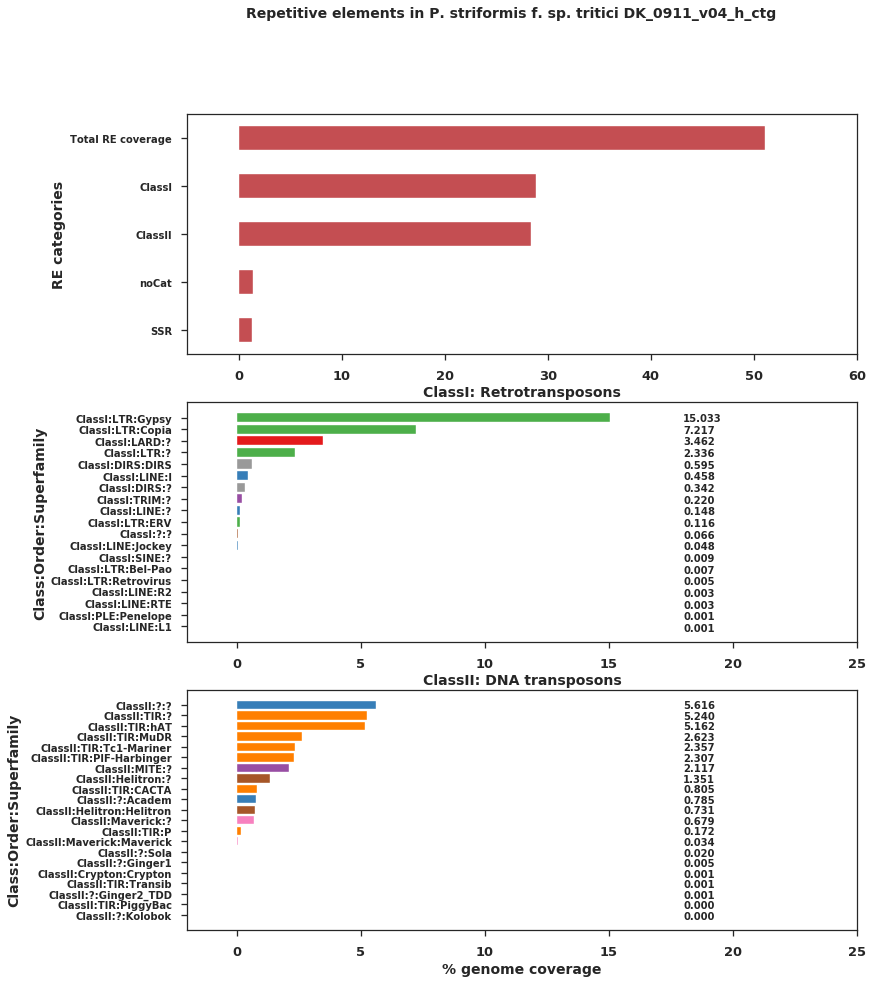

In [81]:
plt.style.use('seaborn-talk')
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(12,15))
fig.suptitle("Repetitive elements in P. striformis f. sp. tritici %s" % genome, fontsize=14, fontweight = 'bold')

#color cycle from color blind people 
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
'#999999', '#e41a1c', '#dede00']

#plot the overall genome coverage by repetitive element category
cov_per_class_df.plot(kind='barh', y='%', ax=ax0,  color='r')
ax0.set_xlim([-5,60])
ax0.legend().set_visible(False)
ax0.set_yticklabels(list(cov_per_class_df.index),fontsize=10, fontweight='bold')
ax0.set_ylabel(ylabel='RE categories', fontsize=14, fontweight='bold')

#plot class I 
classI_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'Retrotransposon'].sort_values('%',\
                                                            ascending=True)
#pick out the colors to do color matching on the order level
tmp_cn = len(classI_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classI_df['Order'].unique(), tmp_colors))
classI_df['Color'] = classI_df['Order'].apply(lambda x: tmp_col_dict[x])
ax1.barh(np.arange(len(classI_df.index)), classI_df['%'],
        color=classI_df['Color'], ecolor='black')
ax1.set_yticks(np.arange(len(classI_df.index)))
ax1.set_xlim([-2,25])
ax1.set_yticklabels(list(classI_df.index),fontsize=10, fontweight='bold')
ax1.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax1.set_title('ClassI: Retrotransposons', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax1.patches, classI_df['%']):
    ax1.annotate('{0:.3f}'.format(value), (18,p.get_y() * 1.005),fontsize=10, fontweight='bold' )

#plot class II
classII_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'DNA_transposon'].sort_values('%',\
                                                                                        ascending=True)

#pick out the colors to do color matching on the order level
tmp_cn = len(classII_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classII_df['Order'].unique(), tmp_colors))
classII_df['Color'] = classII_df['Order'].apply(lambda x: tmp_col_dict[x])

#plot the class II out

ax2.barh(np.arange(len(classII_df.index)), classII_df['%'],
        color=classII_df['Color'], ecolor='black')

ax2.set_xlim([-2,25])
ax2.set_yticks(np.arange(len(classII_df.index)))

ax2.set_yticklabels(list(classII_df.index),fontsize=10, fontweight='bold')
ax2.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax2.set_title('ClassII: DNA transposons', fontsize=14, fontweight='bold')
ax2.set_xlabel('% genome coverage', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax2.patches, classII_df['%']):
    ax2.annotate('{0:.3f}'.format(value), (18 ,p.get_y() * 1.005),fontsize=10, fontweight='bold' )

    
##OUTPATH for figures
   
#fig.savefig(os.path.join(out_dir, genome+'.REPET_summary_pc.seaborn-talk.png'), dpi=600, bbox_inches="tight")
outfn = os.path.join(OUTPATH, genome+'.REPET_summary_pc.seaborn-talk.tiff')
#fig.savefig(outfn, dpi=600, bbox_inches="tight")

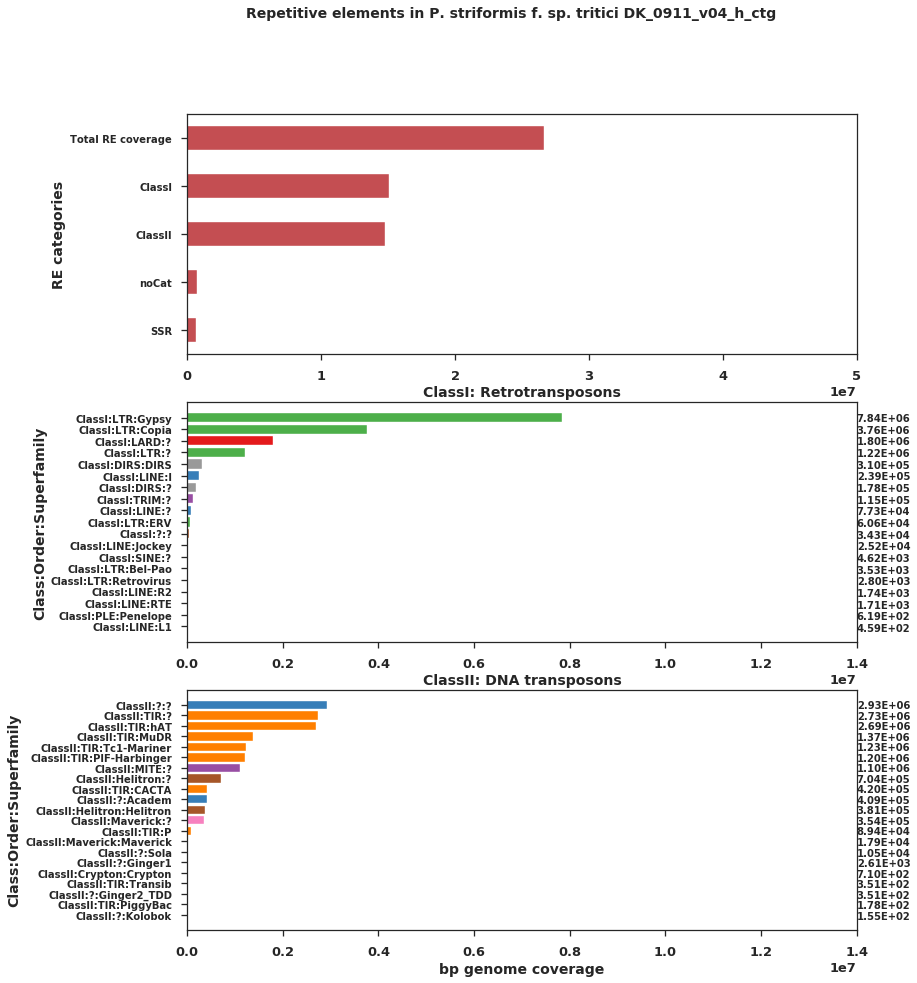

In [80]:
plt.style.use('seaborn-talk')
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(12,15))
fig.suptitle("Repetitive elements in P. striformis f. sp. tritici %s" % genome, fontsize=14, fontweight = 'bold')

#color cycle from color blind people 
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
'#999999', '#e41a1c', '#dede00']

#plot the overall genome coverage by repetitive element category
cov_per_class_df.plot(kind='barh', y='bp', ax=ax0,  color='r')
ax0.set_xlim([-5,50000000])
ax0.legend().set_visible(False)
ax0.set_yticklabels(list(cov_per_class_df.index),fontsize=10, fontweight='bold')
ax0.set_ylabel(ylabel='RE categories', fontsize=14, fontweight='bold')

#plot class I 
classI_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'Retrotransposon'].sort_values('%',\
                                                            ascending=True)
#pick out the colors to do color matching on the order level
tmp_cn = len(classI_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classI_df['Order'].unique(), tmp_colors))
classI_df['Color'] = classI_df['Order'].apply(lambda x: tmp_col_dict[x])
ax1.barh(np.arange(len(classI_df.index)), classI_df['bp'],
        color=classI_df['Color'], ecolor='black')
ax1.set_yticks(np.arange(len(classI_df.index)))
ax1.set_xlim([-2,14000000])
ax1.set_yticklabels(list(classI_df.index),fontsize=10, fontweight='bold')
ax1.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax1.set_title('ClassI: Retrotransposons', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax1.patches, classI_df['bp']):
    ax1.annotate('{0:.2E}'.format(value), (14000000,p.get_y() * 1.005),fontsize=10, fontweight='bold' )

#plot class II
classII_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'DNA_transposon'].sort_values('%',\
                                                                                        ascending=True)

#pick out the colors to do color matching on the order level
tmp_cn = len(classII_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classII_df['Order'].unique(), tmp_colors))
classII_df['Color'] = classII_df['Order'].apply(lambda x: tmp_col_dict[x])

#plot the class II out

ax2.barh(np.arange(len(classII_df.index)), classII_df['bp'],
        color=classII_df['Color'], ecolor='black')

ax2.set_xlim([-2,14000000])
ax2.set_yticks(np.arange(len(classII_df.index)))

ax2.set_yticklabels(list(classII_df.index),fontsize=10, fontweight='bold')
ax2.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax2.set_title('ClassII: DNA transposons', fontsize=14, fontweight='bold')
ax2.set_xlabel('bp genome coverage', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax2.patches, classII_df['bp']):
    ax2.annotate('{0:.2E}'.format(value), (14000000 ,p.get_y() * 1.005),fontsize=10, fontweight='bold' )
    
fig.savefig(os.path.join(out_dir, genome+'.REPET_summary_bpcov.seaborn-talk.png'), dpi=600, bbox_inches="tight")

### Now some analysis of the divergence of the TEs

In [59]:
#now get the summary of allTEs == TEs specificaly identified by TEdenovo from REPET
REPET_denovoTEs_df = pd.read_csv(\
        os.path.join(TE_postanalysis_dir, '%s_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' % genome_repet),\
                                names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#now get in the summary of all bankBLRx TEs == TEs identified by repbase20.05_ntSeq_cleaned_TE
REPET_nt_repbase_df = pd.read_csv(\
    os.path.join(TE_postanalysis_dir, '%s_chr_bankBLRx_path.annotStatsPerTE.tab' % genome_repet) ,\
    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#now get in the summary of all bankBLRtx TEs == TEs identified by repbase20.05_aaSeq_cleaned_TE
REPET_aa_repbase_df = pd.read_csv(\
    os.path.join(TE_postanalysis_dir, '%s_chr_bankBLRtx_path.annotStatsPerTE.tab' % genome_repet) ,\
    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )


In [60]:
#generate a df that contains all TEs: TEdenovo, blastx, blastn
REPET_all_TEs_df = pd.concat([REPET_denovoTEs_df ,REPET_nt_repbase_df,\
                                       REPET_aa_repbase_df], axis=0)

In [61]:
REPET_all_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.copies > 0]
REPET_all_TEs_df = REPET_all_TEs_df[~REPET_all_TEs_df.TE.str.startswith("Potential")]

In [62]:
#update the TE_COS_dict with missing values that come mostly from blastx and blastn searches.
missing_TE_keys = list(set(REPET_all_TEs_df.TE.unique())- set(TE_COS_dict.keys()))
missing_TE_values  = [x[x.find(':')+1:] for x in missing_TE_keys]
TE_COS_dict.update(dict(zip(missing_TE_keys ,missing_TE_values )))

In [63]:
#get the Class/order/superfamily column to the dataframe based on the TE_COS_dict
REPET_all_TEs_df["COS"] = REPET_all_TEs_df["TE"].apply(lambda x: TE_COS_dict[x])

In [64]:
#using the formula T=D/t in arXiv:1209.0176 [q-bio] to approximate TE age
# where D = (100-meanId)/100 and 
# t the substitution rate per site per year
# generations per year are estimate at 15 10.1111/j.1365-294X.2007.03513.x
# estimate of subsitution rate per year = 2 * 10-9 10.1093/oxfordjournals.molbev.a004056 and
# 10.1016/j.fbr.2010.03.001
REPET_all_TEs_df['TE_age_Mya'] = (((100-REPET_all_TEs_df.meanId)/100)\
                                        /(2*10**-9))/10**6
REPET_all_TEs_df['TE_age'] = (((100-REPET_all_TEs_df.meanId)/100)\
                                        /(2*10**-9))
REPET_all_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.copies > 5]


In [65]:
REPET_ClassI_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.COS.str.startswith('ClassI:')]
REPET_ClassII_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.COS.str.startswith('ClassII:')]

In [66]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


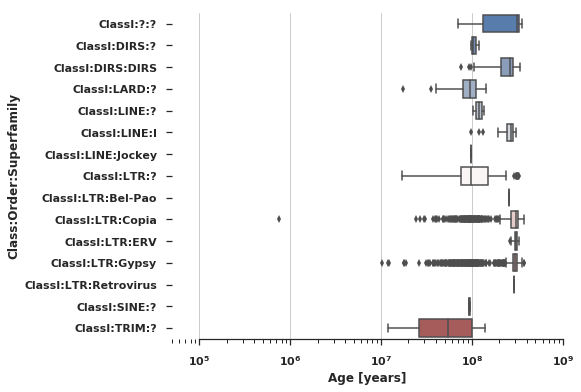

In [67]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

REPET_ClassI_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=REPET_ClassI_TEs_df,palette="vlag")

plt.xlim(5*10**4, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, '%s_%s_ClassI_age.png' % (genome, Tenovodb))

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


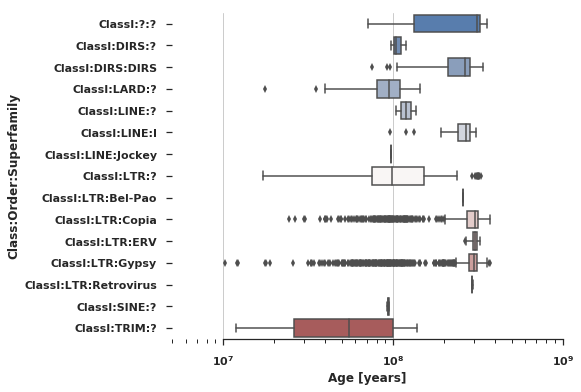

In [68]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

REPET_ClassI_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=REPET_ClassI_TEs_df,palette="vlag")

plt.xlim(5*10**6, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, '%s_%s_ClassI_age.png' % (genome, Tenovodb))
f.savefig(out_fn, dpi=600,bbox_inches="tight")



/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


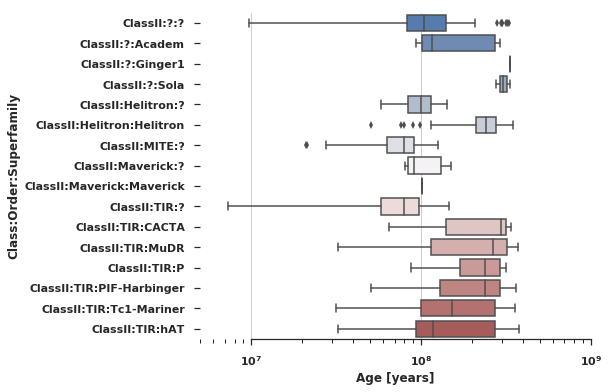

In [69]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

REPET_ClassII_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=REPET_ClassII_TEs_df,palette="vlag")

plt.xlim(5*10**6, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, '%s_%s_ClassII_age.png' % (genome, Tenovodb))
f.savefig(out_fn, dpi=600,bbox_inches="tight")


/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


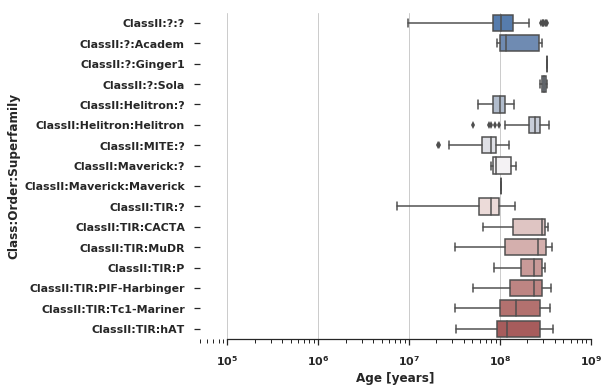

In [70]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

REPET_ClassII_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=REPET_ClassII_TEs_df,palette="vlag")

plt.xlim(5*10**4, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, '%s_%s_ClassII_age.png' % (genome, Tenovodb))

In [71]:
sub_df_young_many = REPET_all_TEs_df[(REPET_all_TEs_df.copies > 50) &( REPET_all_TEs_df.TE_age_Mya < 100)]

In [72]:
sub_df_young_many_by_COS_sum = sub_df_young_many.groupby('COS').sum()

In [73]:
sub_df_young_many_by_COS_sum['Class'] = 'noCat'
sub_df_young_many_by_COS_sum["Index"] = sub_df_young_many_by_COS_sum.index
sub_df_young_many_by_COS_sum['Order'] = 'noCat'
sub_df_young_many_by_COS_sum['Class:Order'] = 'noCat'

In [74]:
#generate Class column or noCat
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Class"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].Index.apply\
(lambda x: x.split(':')[0])

#generate Order column or noCat
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Order"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].Index.apply\
(lambda x: x.split(':')[1])


#generate Class order column
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Class:Order"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')]['Class']\
+ ':' +\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')]['Order']

In [75]:
#get color column sorted
colors = sns.color_palette('cubehelix', n_colors=\
                           len(sub_df_young_many_by_COS_sum['Class:Order'].unique()))
color_dict = dict(zip(sub_df_young_many_by_COS_sum['Class:Order'].unique(), colors))

In [76]:
sub_df_young_many_by_COS_sum['color'] = sub_df_young_many_by_COS_sum['Class:Order'].apply(\
        lambda x: color_dict[x])
color_index_dict = dict(zip(sub_df_young_many_by_COS_sum.Index, sub_df_young_many_by_COS_sum.color))

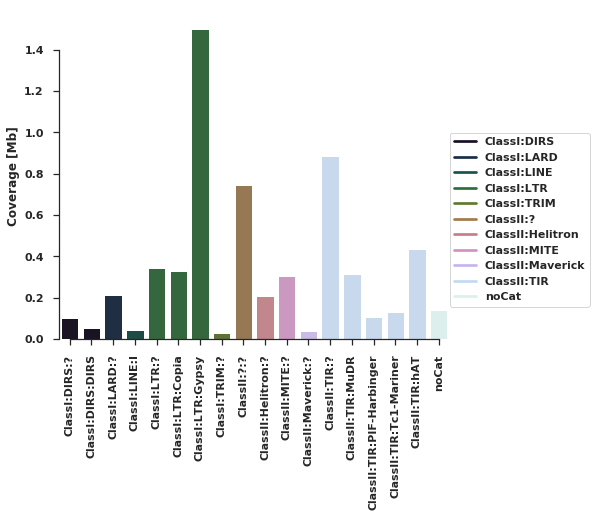

In [77]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
sns.barplot(sub_df_young_many_by_COS_sum.index, sub_df_young_many_by_COS_sum.covg/10**6,\
           palette=color_index_dict)

plt.ylabel("Coverage [Mb]",fontsize = 12, weight= 'bold')
plt.xlabel("",fontsize = 12, weight= 'bold'"")
sns.despine(trim=True)

#change the colors of the legend
key_list = list(color_dict.keys())
key_list.sort()
plt.legend(key_list, loc=(1, 0.1))
leg = ax.get_legend()
for (x,y) in zip(key_list, leg.legendHandles):
    y.set_color(color_dict[x])
    


for l in ax.get_xticklabels():
    l.set_rotation(90)

out_fn = os.path.join(out_dir, '%s_%s_TEs_young_and_plenty.png'  % (genome, Tenovodb))
f.savefig(out_fn, dpi=600, bbox_inches="tight")



#### For haplotigs run up to here